# Predicting Taiwan Credit Card Default
## Austin Martinez, David Beach, Derek McFate

## Introduction 

The dataset we are working with is collection of client specifications and history from a Taiwan credit card company that is coupled with their credit card default status. Throughout this notebook we explore various trends with the data, process the data, and create optomized machine learning classifiers to predict a client's likelihood to default.




In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn import preprocessing as skp
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import tree
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import r2_score


dat = pd.read_csv("https://raw.githubusercontent.com/DerekMcFate/MachineLearningProject/master/default_cc_train.csv")

## Data Preprocessing

We renamed the data column 'default.payment.next.month' to 'DEFAULT' in order to make it easier to work with. The Education and Marriage columns had zero values that didn't have any explaination, so we decided to remove them from the dataset. Education contained values from 0-6, but there weren't any descriptions for 5 and 6, so we merged them both into 5. We also drop the ID field, as every entry will be unique.

In [2]:
# Rename our label as "DEFAULT"
dat = dat.rename(index=str, columns={"default.payment.next.month": "DEFAULT"})

# Throw away education=0 and marriage=0, and combine education=5,6 as both are 'unknown'
dat['EDUCATION'].replace(6, 5, inplace=True)
dat = dat[dat['EDUCATION'] != 0]
dat = dat[dat.MARRIAGE != 0]
dat = dat.drop(columns=['ID'])

We will also create a scaled copy of our data. 

In [3]:
scaler = skp.StandardScaler()
datScale = pd.DataFrame(scaler.fit_transform(dat.drop(columns=['DEFAULT'])))
# `datScale['DEFAULT'] = dat['DEFAULT']` Does not work for some reason
datScale['DEFAULT'] = dat['DEFAULT']
for i in range(0, dat.shape[0]):
    datScale['DEFAULT'][i] = dat['DEFAULT'][i]

## Data Exploration

In this plot we show the density of Ages that are represented in the dataset. Most of the people are in their 20's and 30's.

C:\Users\cauly\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


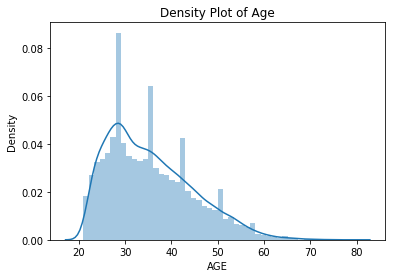

In [4]:
fig = sns.distplot(dat["AGE"])
plt.xlabel("Age")
plt.ylabel("Density")
plt.title("Density Plot of Age") 
plt.show(fig)

Here is the age density by default status with default being blue and not default being orange. Those that do not default being slighty more in the 25-35 years old rage than those that do default.  

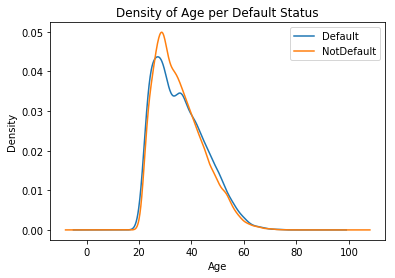

In [5]:
datDef = dat[dat["DEFAULT"] == 1]
datnoDef = dat[dat["DEFAULT"] == 0]
datAge = pd.DataFrame({'Default':datDef["AGE"],'Not Default':datnoDef["AGE"]})
fig = datAge.plot.kde()
plt.xlabel("Age")
plt.ylabel("Density")
plt.title("Density of Age per Default Status") 
plt.show(fig)

Here are the percentage of each sex that defaults with 1 representing male and 2 representing female. The percentage of males that default are slightly higher than the percentage females. This is with the data set being mostly female.

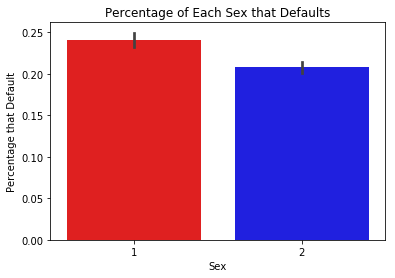

2    15072
1     9871
Name: SEX, dtype: int64

In [6]:
fig = sns.barplot(dat["SEX"],dat["DEFAULT"],palette=["red","blue"])
plt.xlabel("Sex")
plt.ylabel("Percentage that Default")
plt.title("Percentage of Each Sex that Defaults") 
plt.show(fig)
#more women
dat["SEX"].value_counts()


Here we show the percentage that default from each education level. The lower three levels are far more likely to default than the last two. Also there is a slight diffence between the default percentage between men and women with men having more examples of defaulting in every education group. 

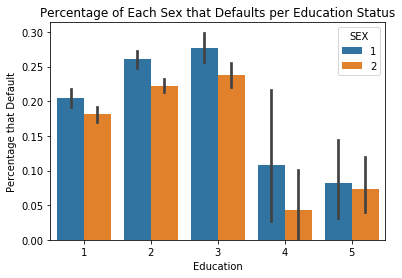

In [7]:
fig = sns.barplot(dat["EDUCATION"],dat["DEFAULT"],hue = dat["SEX"])
plt.xlabel("Education")
plt.ylabel("Percentage that Default")
plt.title("Percentage of Each Sex that Defaults per Education Status") 
plt.show(fig)

This plot shows the percentage that default in the three marriage categories. It would appear that being unmarried makes a client less likely to default.

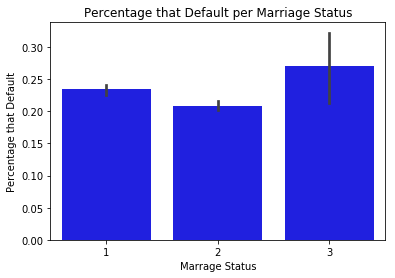

In [8]:
fig = sns.barplot(dat["MARRIAGE"],dat["DEFAULT"],palette=["blue"])
plt.xlabel("Marrage Status")
plt.ylabel("Percentage that Default")
plt.title("Percentage that Default per Marriage Status") 
plt.show(fig)

This plot show the density of balance limit per default status. There is a larger percentage of those that have a low balance limit defaulting. 

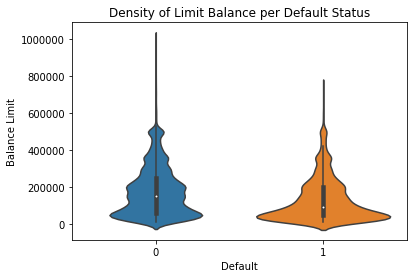

In [9]:
fig = sns.violinplot(dat["DEFAULT"],dat["LIMIT_BAL"])
plt.xlabel("Default")
plt.ylabel("Balance Limit")
plt.title("Density of Limit Balance per Default Status") 
plt.show(fig)

Here are the percentage that each payment delay status will default for the months of May and September. A few key trends to note is that if the balance is paid off completely then the client is very unlikely to default while if there are one or more months of not paying they are more likely to default. Also it is interesting to note that if a client has not paid for eight months in may they 100% default while it is 50-50 chance of them defaulting in the most recent month(september) with eight months not paid.

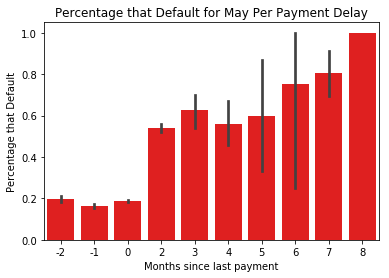

In [10]:
fig = sns.barplot(dat["PAY_5"],dat["DEFAULT"],palette=["red"])
plt.xlabel("Months since last payment")
plt.ylabel("Percentage that Default")
plt.title("Percentage that Default for May Per Payment Delay") 
plt.show(fig)

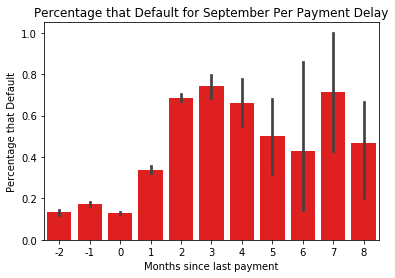

In [11]:
fig = sns.barplot(dat["PAY_0"],dat["DEFAULT"],palette=["red"])
plt.xlabel("Months since last payment")
plt.ylabel("Percentage that Default")
plt.title("Percentage that Default for September Per Payment Delay") 
plt.show(fig)

## Machine Learning

### Logistic Regression Model

Let us try classifying using a logistic regression model. First we split our data into testing and training sets. From there, we can fit the data to our model and test it. We can see that the accuracy of the model is in the upper 70s.  

In [44]:
X = dat.drop(columns=['DEFAULT'])
y = dat['DEFAULT']

#scaler = skp.StandardScaler()
#dat = scaler.fit_transform(X)

logi = LogisticRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
logi.fit(pd.DataFrame(X_train), y_train)
logi.score(pd.DataFrame(X_test), y_test)

0.776107436359992

Here we create a function to plot the learning curve of our model. In the case of our Logistic Model, both lines reach their finalized values relatively quickly

Plotting the learning curve. it looks clean. 

<module 'matplotlib.pyplot' from '/Users/scrambles/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

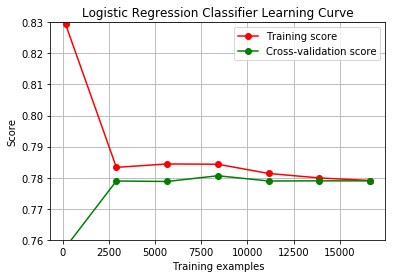

In [45]:
def plot_learning_curve(estimator, title, X, y, train_sizes=np.linspace(.01, 1.0, 7), ylimit=[.76, .83]):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=None, n_jobs=None, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    plt.grid()
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    plt.ylim((0, 1))
    return plt

plot_learning_curve(logi, "Logistic Regression Classifier Learning Curve", X, y)

However, despite the score and clarity of the learning curve, we can see the fault in the model if we look at the confusion matrix. This model effectively only gives a single answer almost every time. So the accuracy of the model directly correlates with the percentage of the non-defaulting labels within our data. 

In [46]:
pred = logi.predict(pd.DataFrame(X_test))
confusion_matrix(y_test, pred)

array([[3872,    4],
       [1113,    0]])

If we look at the percentage of 0s in the labels, we can see that our model slightly varies from only guessing 'not default'

In [47]:
y.value_counts()[0]/len(y)

0.7791364310628233

### SVM
If we use a support vector machine without the use of kernals, we can get roughly the same accuracy as we did with the logistic regression model.

In [48]:
sv = SVC()
sv.fit(X_train, y_train)
sv.score(X_test, y_test)

0.777510523150932

The resulting confusion matrix from the SVM shows that the same problem is occuring. This means that we must transform our data or derive more data that fits better with our models. 

In [49]:
pred = sv.predict(pd.DataFrame(X_test))
confusion_matrix(y_test, pred)

array([[3861,   15],
       [1095,   18]])

## Hyperparameter Tuning

We wanted to see if we could get more accurate results by changing some of the SVC's hyperparameters. In order to find a more optimal set, we used a Randomized Search to find which values worked best.

In [ ]:
sv.get_params()
params = {'C': [.1, 1, 10], 'gamma': ['auto'], 'kernel': ['rbf'], 'class_weight': ['balanced', None]}
randS = RandomizedSearchCV(sv, params, n_iter=1)
randS.fit(X_train, y_train)
print(randS.best_params_)

The Randomized Search determined that setting the 'C' value to .1 instead of the default 1 could lead to more accurate results.

In [ ]:
newSV = SVC(C=.1, kernel='rbf', gamma='auto', class_weight=None)
newSV.fit(X_train, y_train)
sv.score(X_test, y_test)

Unfortunately, the changes made to the hyperparameters gave the same accuracy as when we used the default SVC constructor. This could be due to the Randomized Search function not being able to find any similarities or patterns within the dataset. It could also be caused by having too few parameters to select from, but the run-time began to increase dramatically with every new parameter measured. 

# Dimension Reduction 

Lets try using component analysis to reduce our dimensions and work with more selective features. 

In [50]:
prince = PCA(n_components=2)
comps = pd.DataFrame(prince.fit_transform(datScale), columns=['pc1', 'pc2'])
# `comps['DEFAULT'] = dat['DEFAULT']` Does not work for some reason
comps['DEFAULT'] = dat['DEFAULT']
for i in range(0, dat.shape[0]):
    comps['DEFAULT'][i] = dat['DEFAULT'][i]

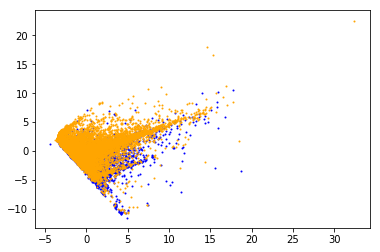

In [51]:
spl = comps[comps['DEFAULT'] == 1]
spl2 = comps[comps['DEFAULT'] == 0]

plt.scatter(spl['pc1'], spl['pc2'], color='blue', s=1)
plt.scatter(spl2['pc1'], spl2['pc2'], color='orange', s=1)

In [77]:
Xtrain, Xtest, ytrain, ytest = train_test_split(comps.drop(columns=['DEFAULT']), 
                                                           comps['DEFAULT'], 
                                                           test_size=0.1)

nb = GaussianNB()
nb.fit(Xtrain, ytrain)
nb.score(Xtest, ytest)

0.8012024048096192

<module 'matplotlib.pyplot' from '/Users/scrambles/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

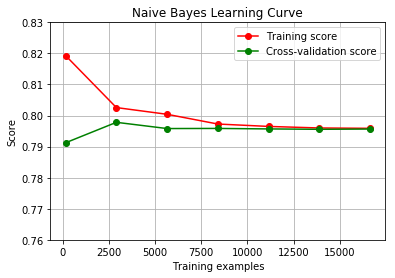

In [67]:
plot_learning_curve(nb, 
                    'Naive Bayes Learning Curve', 
                    comps.drop(columns=['DEFAULT']), 
                    comps['DEFAULT'], 
                    train_sizes=np.linspace(.01, 1.0, 7))

In [53]:
class StackingRegressor(BaseEstimator, ClassifierMixin):
    def __init__(self, predictors):
        self.preds = predictors
    def fit(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
        levelFeatures = []
        for i in self.preds:
            i.fit(X_train, y_train)
            temp = i.predict(X_test)
            levelFeatures.append(np.array(temp))
        levelFeatures = list(map(list, zip(*levelFeatures)))
        self.blender = GaussianNB()
        return self.blender.fit(levelFeatures, y_test)  
    def predict(self, X):
        pr_list = []
        for i in self.preds:
            pr_list.append(np.array(i.predict(X)))
        pr_list = list(map(list, zip(*pr_list)))
        return self.blender.predict(pr_list)

In [78]:
logi = LogisticRegression()
nb = GaussianNB()
dtc = tree.DecisionTreeClassifier()

regr = StackingRegressor([logi, nb, dtc])
regr.fit(Xtrain, ytrain)
y_predict = regr.predict(Xtest)
count = 0
sum(y_predict == ytest)/len(y_predict)

0.8028056112224449

## Conclusion

Using techniques such as dimensionality reduction in the form of PCA, ensemble methods like our Stacking Regressor, and systematicly tuning hyperparameters with Randomized Search we were able to predict client defaulting up to an accurancy of 80%. Also, through data exploration we were able to find that there are some minor relationships between likelihood of defauting and attributes such as sex, age, balance limit, and amount of education.  
